In [17]:
import pandas as pd
import numpy as np
import os
import random

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [18]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import squarify
import matplotlib.pyplot as plt
plt.style.use("default")
from IPython.display import Image

In [19]:
path = '/opt/ml/input/data/'
# # train = pd.read_csv(path + 'train_data.csv')
# # test = pd.read_csv(path + 'test_data.csv')
train = pd.read_csv(path + 'FE/FE_total2.csv')

train = train.sort_values(by = ['userID', 'Timestamp'])
train['tem'] = 0

_train = train[train['answerCode'] >= 0]
_test = train[train['answerCode'] == -1]

In [20]:
_train['row_id'] = _train.index

/tmp/ipykernel_26655/2869465940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _train['row_id'] = _train.index


In [21]:
_train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solve_time,b_category,test_category,problem_id,...,last_answerCode7,last_answerCode8,last_answerCode9,last_answerCode10,year,month,day,hour,tem,row_id
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,6,6001,1,...,1,1,1,1,2020,3,24,0,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3,6,6001,2,...,1,1,1,1,2020,3,24,0,0,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8,6,6001,3,...,1,1,1,1,2020,3,24,0,0,2
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7,6,6001,4,...,1,1,1,1,2020,3,24,0,0,3
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7,6,6001,5,...,1,1,1,1,2020,3,24,0,0,4


In [22]:
def convert_from_ms(milliseconds):
    seconds, milliseconds = divmod(milliseconds, 1000)
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    days, hours = divmod(hours, 24)
    seconds = seconds + milliseconds / 1000
    return days, hours, minutes, round(seconds)

In [31]:
_train.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'solve_time', 'b_category', 'test_category',
       'problem_id', 'category_st_qcut_5', 'last_answerCode',
       'last_answerCode2', 'last_answerCode3', 'last_answerCode4',
       'last_answerCode5', 'last_answerCode6', 'last_answerCode7',
       'last_answerCode8', 'last_answerCode9', 'last_answerCode10', 'year',
       'month', 'day', 'hour', 'tem', 'row_id'],
      dtype='object')

In [72]:
_train.groupby('userID')['solve_time'].apply(lambda x : x.cumsum())

0            0
1            3
2           11
3           18
4           25
          ... 
2526695    220
2526696    220
2526697    231
2526698    277
2526699    350
Name: solve_time, Length: 2525956, dtype: int64

In [73]:
_train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solve_time,b_category,test_category,problem_id,...,last_answerCode8,last_answerCode9,last_answerCode10,year,month,day,hour,tem,row_id,user_time_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,6,6001,1,...,1,1,1,2020,3,24,0,0,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3,6,6001,2,...,1,1,1,2020,3,24,0,0,1,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8,6,6001,3,...,1,1,1,2020,3,24,0,0,2,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7,6,6001,4,...,1,1,1,2020,3,24,0,0,3,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7,6,6001,5,...,1,1,1,2020,3,24,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24,3,3071,5,...,1,1,1,2020,6,5,6,0,2526695,0
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0,4,4165,1,...,1,1,1,2020,8,21,1,0,2526696,0
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11,4,4165,2,...,1,1,1,2020,8,21,1,0,2526697,0
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46,4,4165,3,...,1,1,1,2020,8,21,1,0,2526698,0


1. Building the user dataframe

In [74]:
agg = {'row_id' : 'count',
       'solve_time' : lambda x: convert_from_ms(x.max())[0],
       'answerCode' : lambda x: round(x.mean() * 100)}

user_info = _train.groupby('userID').agg(agg)

In [77]:
agg = {'row_id' : 'count',
       'solve_time' : lambda x: convert_from_ms(x.max())[0],
       'answerCode' : lambda x: round(x.mean() * 100)}

user_info = _train.groupby('userID').agg(agg)
user_info = user_info.rename(columns={'row_id' : 'nb_interactions',
                                   'solve_time' : 'nb_jours',
                                   'answerCode' : 'score'})
user_info

,nb_interactions,nb_jours,score
userID,,,
0,745,0,63
1,933,0,85
2,276,0,61
3,1035,0,69
4,670,0,69
...,...,...,...
7437,16,0,38
7438,16,0,75
7439,15,0,73


In [78]:
user_info.describe(percentiles=[.05, .25, .5, .75, 0.95])

,nb_interactions,nb_jours,score
count,7442.000000,7442.0,7442.000000
mean,339.418973,0.0,62.873555
std,321.465413,0.0,15.960752
min,9.000000,0.0,0.000000
5%,23.000000,0.0,33.000000
25%,78.000000,0.0,53.000000
50%,232.500000,0.0,65.000000
75%,519.000000,0.0,75.000000
95%,985.000000,0.0,85.000000
max,1860.000000,0.0,100.000000


CPU times: user 2.54 s, sys: 76 ms, total: 2.61 s
Wall time: 1.91 s


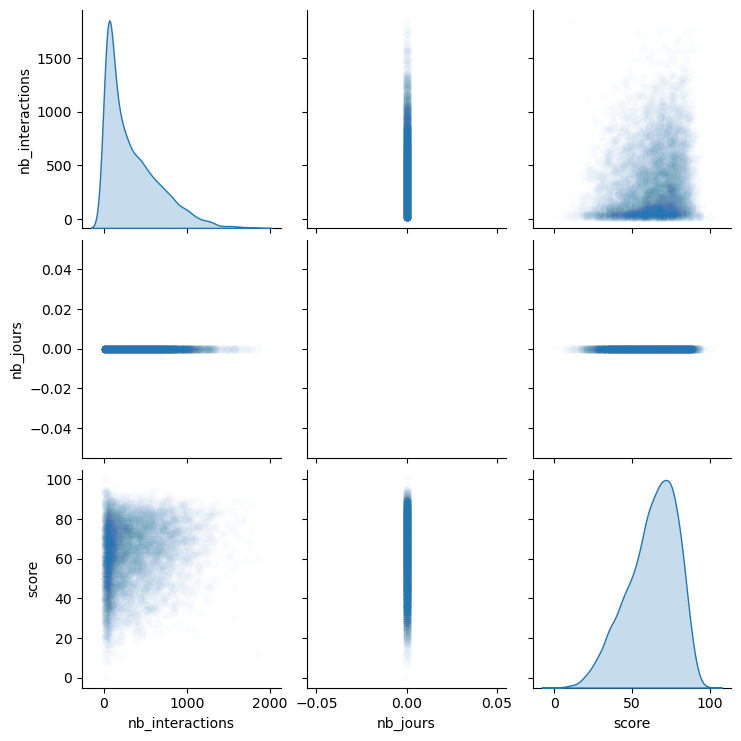

In [80]:
%%time
fig = sns.pairplot(user_info, diag_kind="kde", plot_kws={'alpha': 0.01})

/tmp/ipykernel_26655/3810270556.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_info.nb_interactions, hist=False)


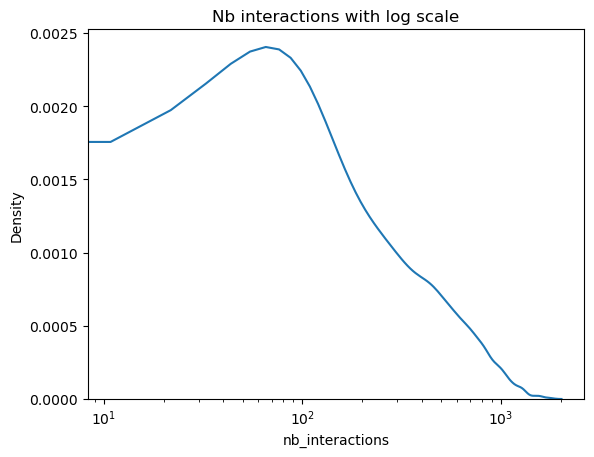

In [81]:
sns.distplot(user_info.nb_interactions, hist=False)
plt.xscale('log')
plt.title('Nb interactions with log scale')

/tmp/ipykernel_26655/3810270556.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_info.nb_interactions, hist=False)


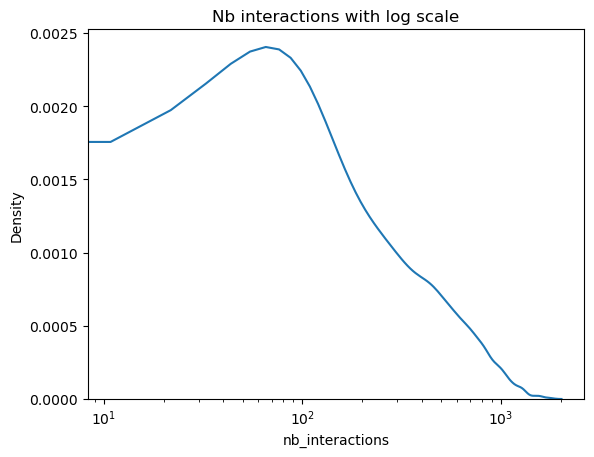

In [82]:
sns.distplot(user_info.nb_interactions, hist=False)
plt.xscale('log')
plt.title('Nb interactions with log scale')

/tmp/ipykernel_26655/1174564973.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_info.nb_jours, hist=False)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2517: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_26655/1174564973.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


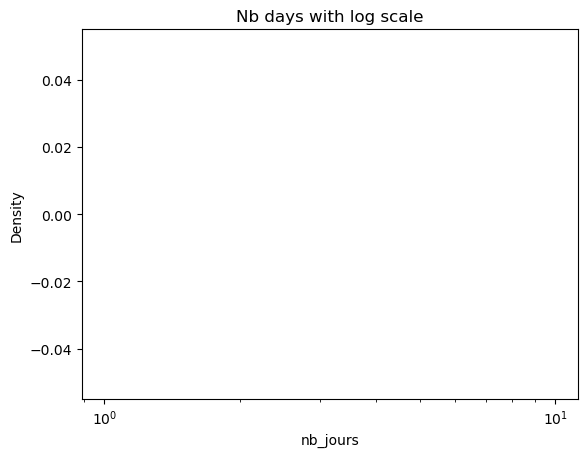

In [83]:
sns.distplot(user_info.nb_jours, hist=False)
plt.xscale('log')
plt.title('Nb days with log scale')

2. Number of interactions per user

[(0.0, 500.0), Text(0.5, 1.0, 'Focus on the box'), Text(0, 0.5, '')]

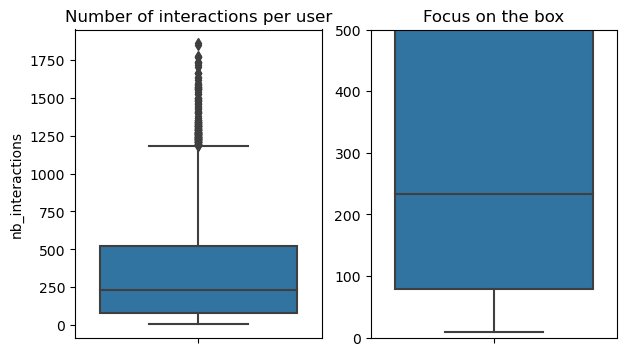

In [84]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(7,4))
sns.boxplot(y=user_info['nb_interactions'], ax=ax0)
sns.boxplot(y=user_info['nb_interactions'], ax=ax1)
ax0.set(title="Number of interactions per user")
ax1.set(ylim=(0,500), title="Focus on the box", ylabel="")

3. Number of days between the first interaction and the last

[(0.0, 150.0), Text(0.5, 1.0, 'Focus on the box'), Text(0, 0.5, '')]

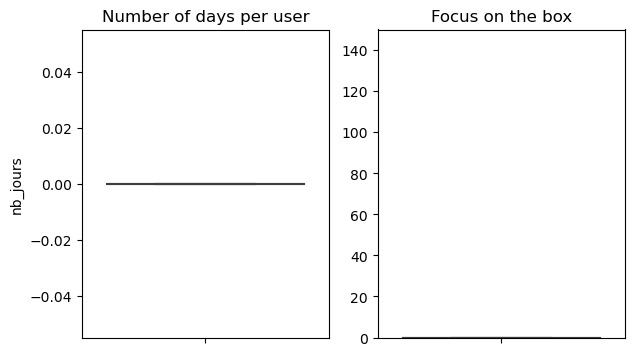

In [85]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(7,4))
sns.boxplot(y=user_info['nb_jours'], ax=ax0)
sns.boxplot(y=user_info['nb_jours'], ax=ax1)
ax0.set(title="Number of days per user")
ax1.set(ylim=(0,150), title="Focus on the box", ylabel="")

4. Apply filters

In [86]:
# Set cleaning thresholds here
Q1 = 0.05
Q4 = 0.95

# Filter of exceptional interactions
q1_int = user_info.nb_interactions.quantile(Q1)
q4_int = user_info.nb_interactions.quantile(Q4)
cond_int = (user_info.nb_interactions > q1_int) & (user_info.nb_interactions < q4_int)

# Filter of exceptional deadlines
q1_delay = user_info.nb_jours.quantile(Q1)
q4_delay = user_info.nb_jours.quantile(Q4)
cond_delay = (user_info.nb_jours > q1_delay) & (user_info.nb_jours < q4_delay)

reduced_user_info = user_info[cond_int & cond_delay]
reduced_user_info

,nb_interactions,nb_jours,score
userID,,,


In [87]:
reduced_n_user = len(reduced_user_info)

reduced_user_rate = round((1 - reduced_n_user / len(user_info)) * 100)
print(f'Users have been reduced by {reduced_user_rate} %.')

Users have been reduced by 100 %.


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:1310: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.hue_vals = pd.Series(["_nolegend_"] * len(data),


CPU times: user 644 ms, sys: 8 ms, total: 652 ms
Wall time: 653 ms


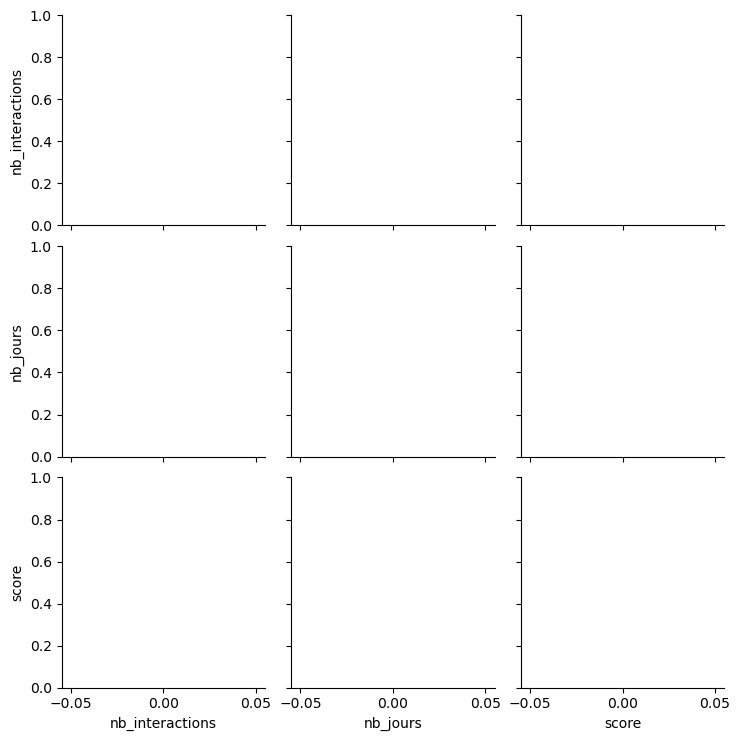

In [88]:
%%time
fig = sns.pairplot(reduced_user_info,  diag_kind="kde", plot_kws={'alpha': 0.01})

/tmp/ipykernel_26655/1370371831.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reduced_user_info.nb_interactions, hist=False)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2485: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Nb interactions with log scale')

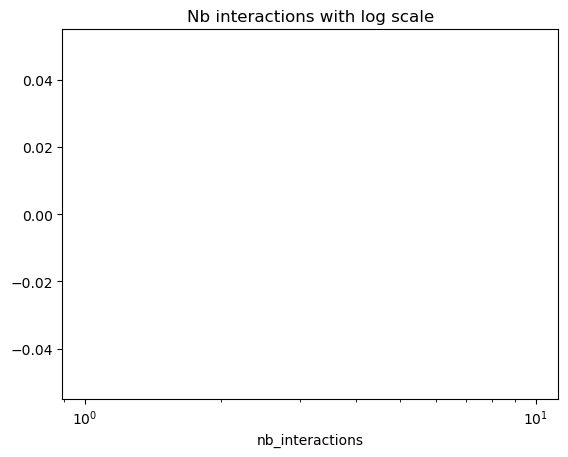

In [89]:
sns.distplot(reduced_user_info.nb_interactions, hist=False)
plt.xscale('log')
plt.title('Nb interactions with log scale')

/tmp/ipykernel_26655/2177714367.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reduced_user_info.nb_jours, hist=False)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2485: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Nb days with log scale')

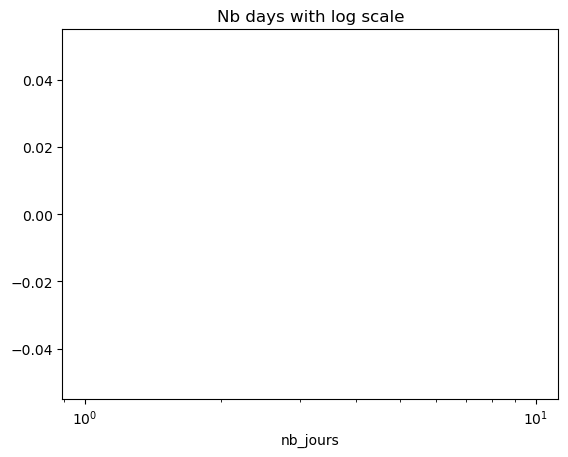

In [90]:
sns.distplot(reduced_user_info.nb_jours, hist=False)
plt.xscale('log')
plt.title('Nb days with log scale')

In [92]:
reduced__train = pd.merge(_train, reduced_user_info, on='userID')

col = _train.columns
reduced__train = reduced__train[col]
reduced__train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solve_time,b_category,test_category,problem_id,...,last_answerCode8,last_answerCode9,last_answerCode10,year,month,day,hour,tem,row_id,user_time_sum


In [93]:
reduced_train_rate = round((1 - len(reduced__train) / len(_train)) * 100)
print(f'Interactions were reduced by {reduced_train_rate} %.')

Interactions were reduced by 100 %.


Features engineering

1. Help usage

In [95]:
help_usage = reduced__train[reduced__train.answerCode == -1].groupby('userID')['problem_id'].count()
help_usage = help_usage.reset_index().rename(columns={'problem_id': 'help_usage'})
help_usage

,userID,help_usage


In [96]:
help_usage.describe()

,userID,help_usage
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


Text(0.5, 1.0, 'Help usage of users')

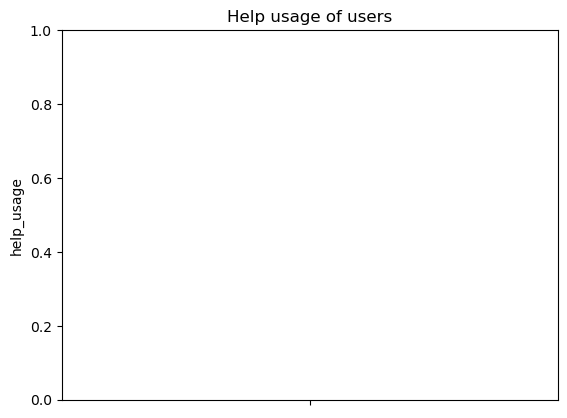

In [97]:
sns.boxplot(y='help_usage', data=help_usage)
plt.title('Help usage of users')

In [98]:
help_usage['binned_help_usage'] = pd.cut(help_usage['help_usage'], bins=[-np.inf, 0, 1, 3, np.inf], labels=[0, 1, 2, 3])
help_usage

,userID,help_usage,binned_help_usage


In [117]:
reduced__train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solve_time,b_category,test_category,problem_id,...,last_answerCode8,last_answerCode9,last_answerCode10,year,month,day,hour,tem,row_id,user_time_sum


In [119]:
# Export file for submissions
col = ['userID', 'binned_help_usage']
help_usage = help_usage[col]
# help_usage[col].to_csv('./help.csv', index=False)

# Delete conferences
reduced_train = reduced__train[reduced__train.KnowledgeTag == 0]
reduced_train.shape

(0, 28)

2. Content difficult

In [102]:
col = ['problem_id','KnowledgeTag']
questions = _train[col]
questions = questions.rename(columns={'question_id': 'content_id'})

In [103]:
questions = questions.rename(columns={'b_category': 'Difficulty_level'})

In [104]:
questions = questions.rename(columns={'test_category' : 'part'})

3. New features exploration

In [120]:
featured_train = pd.merge(reduced_train, help_usage, on='userID', how='left')
featured_train = pd.merge(featured_train, questions, on='KnowledgeTag', how='left')
# Users with no help usage equals 0
featured_train.binned_help_usage = featured_train.binned_help_usage.fillna(0)

In [121]:
featured_train.columns

Index(['assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'solve_time',
       'b_category', 'test_category', 'problem_id_x', 'category_st_qcut_5',
       'last_answerCode', 'last_answerCode2', 'last_answerCode3',
       'last_answerCode4', 'last_answerCode5', 'last_answerCode6',
       'last_answerCode7', 'last_answerCode8', 'last_answerCode9',
       'last_answerCode10', 'year', 'month', 'day', 'hour', 'tem', 'row_id',
       'user_time_sum', 'userID', 'binned_help_usage', 'problem_id_y',
       'KnowledgeTag'],
      dtype='object')

In [122]:
%%time

agg = {'row_id' : 'count',
       'answerCode' : lambda x: round(x.mean() * 100),
       'prior_question_had_explanation' : lambda x: round(x.mean() * 100)}

part_info = featured_train.groupby('part').agg(agg)
part_info = part_info.rename(columns={'row_id' : 'nb_interactions',
                                   'answerCode' : 'score'})
part_info

KeyError: 'part'

In [110]:
norm = matplotlib.colors.Normalize(vmin=min(part_info.score), vmax=max(part_info.score))
colors = [matplotlib.cm.Blues(norm(value)) for value in part_info.score]
squarify.plot(sizes=part_info.nb_interactions, color=colors, label=part_info.index, alpha=0.8)
plt.title("Part of test")
plt.axis('off')
plt.show()

NameError: name 'part_info' is not defined

Text(0.5, 1.0, 'Users by help usage group ')

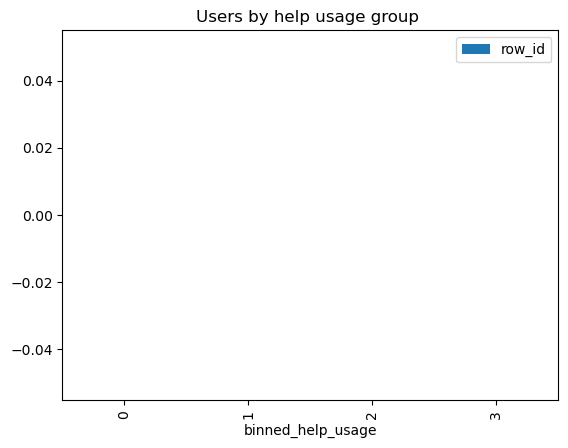

In [111]:
# Level usage

featured_train.groupby('binned_help_usage')['row_id'].count().reset_index().plot.bar(x='binned_help_usage', y='row_id')
plt.title('Users by help usage group ')

4. Reduced train dataset export

In [112]:
col = ['solve_time', 'userID', 'KnowledgeTag',
       'task_container_id', 'binned_help_usage', 'Difficulty_level', 'answerCode']
featured_train = featured_train[col]
featured_train.sample(20)

KeyError: "['timestamp', 'content_id', 'task_container_id', 'Difficulty_level'] not in index"